# Add IFN-gammm inhibition on virus infecting healthy cells.

# functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from AveragePlot import *
import warnings
import seaborn as sns
import os

from new_model import *

warnings.filterwarnings('error')


ggcolors = ['#808080', '#2CA02C', '#1F77B4', '#FF7F0E',
            '#D62728', '#4DBEEE', '#77AC30', '#9467BD']

# Find fixed K_IFNg effect on different modes

In [2]:
data = {'para': [], 'mode': [], 'new_mode': [],
        'k_IFNg': [], 'sol': []}

k_IFNg_list = [0, 0.1, 0.5]

# Load sampling parameters
for m in [1, 2, 3, 4]:
    Paraset = np.loadtxt('Spl_Para%i.txt' % m)
    for p in Paraset:
        for k in k_IFNg_list:
            data['para'].append(np.append(p, k))
            data['mode'].append(m)
            data['k_IFNg'].append(k)

# solutions
proc = multiprocessing.Pool(processes=os.cpu_count()-2)

cnt = 1
for y in proc.imap(get_mode, data['para']):

    data['new_mode'].append(y[0])
    data['sol'].append(y[1])

    print('\r %.2f %%' % (cnt/len(data['para'])*100), end='')
    cnt = cnt + 1

proc.close()

 100.00 %

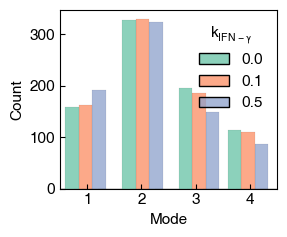

In [3]:
plt.figure(figsize=(3, 2.5))
hplt = sns.histplot(data=data, x='new_mode', hue='k_IFNg',
                    multiple="dodge", shrink=5,
                    palette="Set2")
hplt.get_legend().set_title(r'$k_{IFN-\gamma}$')
hplt.get_legend().draw_frame(False)
hplt.set_xlim([0.5, 4.5])
hplt.set_xticks([1, 2, 3, 4])
hplt.set_xlabel('Mode')
plt.tight_layout()
plt.savefig('Distribution_IFNg.png', dpi=200)
plt.savefig('Distribution_IFNg.svg', dpi=200)

## check one parameter set

In [4]:
# compute 
num = 1500
Para_select = data['para'][num]

mode_list = []
sol_list = []

for k_IFNg in k_IFNg_list:
    Para_select[-1] = k_IFNg
    mode_new, sol_new, _ = get_mode(Para_select)

    mode_list.append(mode_new)
    sol_list.append(sol_new)

Text(0, 0.5, '$k_{infect}(t)$')

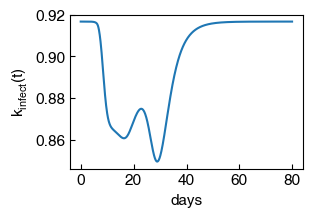

In [5]:
# k_infect change
Time = np.arange(0, 80, 0.1)

# IFNg effect
plt.figure(figsize=(3,2))
plt.plot(Time, (1-k_IFNg*sol_new[:,29]/(50+sol_new[:,29])))
plt.xlabel('days')
plt.ylabel(r'$k_{infect}(t)$')

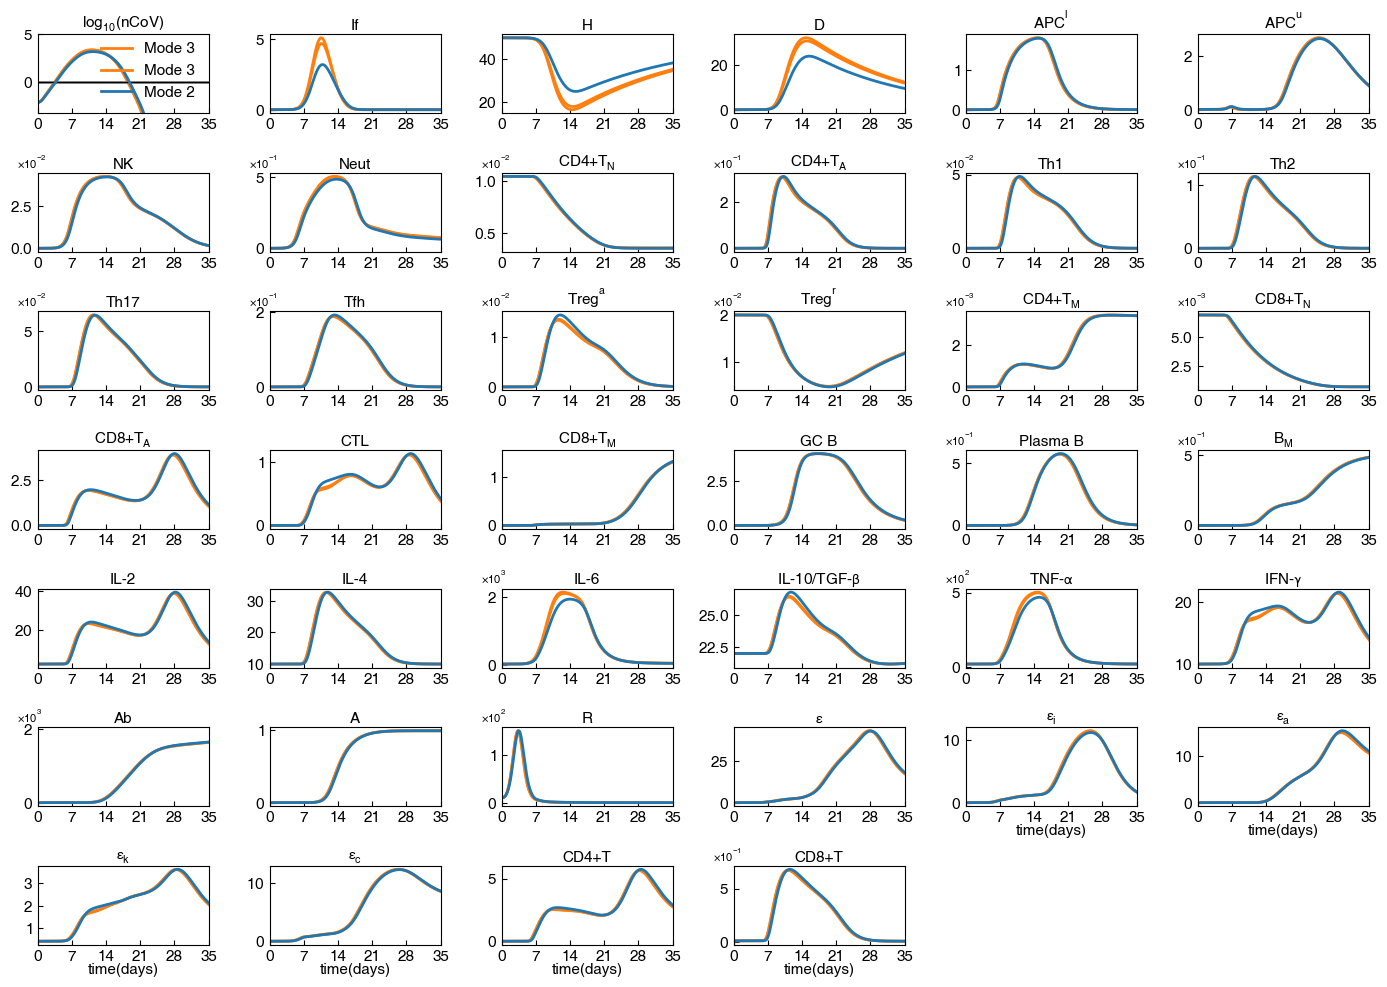

In [6]:
# time course of all variables
fig, ax = plt.subplots(7, 6, figsize=(14, 10))
ax = ax.flat

for sol, mode in zip(sol_list, mode_list):
    averPlot(ax, Time, sol, ggcolors[mode], mode)

for a in ax:
    a.set_xlim([0, 35])
ax[0].legend()
plt.tight_layout()

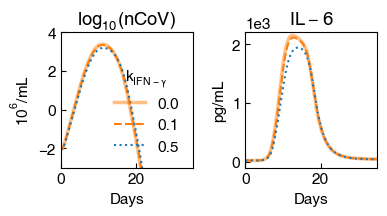

In [7]:
# Time course of VL and IL-6
fig, ax = plt.subplots(1,2,figsize=(4, 2.3))
ls_list = ['-', '--', ':']

for i in range(3):
    sol = sol_list[i]
    mode = mode_list[i]
    lstyle = ls_list[i]
    k_IFNg = k_IFNg_list[i]

    if i == 0:
        alpha = 0.5
        lw = 2.5
    else:
        alpha = 1
        lw = 1.5

    ax[0].plot(Time, sol[:, 0], 
               alpha = alpha, ls = lstyle,
               lw = lw,
               c=ggcolors[mode], 
               label='%.1f' %(k_IFNg))
    ax[1].plot(Time, sol[:, 26], 
               alpha = alpha, ls = lstyle,
               lw = lw,
               c=ggcolors[mode], 
               label='%.1f' %k_IFNg)


ax[0].legend(title=r'$k_{IFN-\gamma}$')
ax[0].set_xlim([0,35])
ax[0].set_ylim([-3,4])
ax[0].set_title(r'$log_{10}(nCoV)$')
ax[0].set_ylabel(r'$10^6/mL$')
ax[0].set_xlabel('Days')

ax[1].set_xlim([0,35])
ax[1].set_ylim([-100,2200])
ax[1].set_title(r'$IL-6$')
ax[1].set_ylabel('pg/mL')
ax[1].set_xlabel('Days')
ax[1].ticklabel_format(style='sci', scilimits=(-1,2), axis='y')

fig.tight_layout()
fig.subplots_adjust(wspace=0.4)
# fig.savefig('Example_IFNg.png', dpi=200)
# fig.savefig('Example_IFNg.svg', dpi=200)

## check main results of averaged results

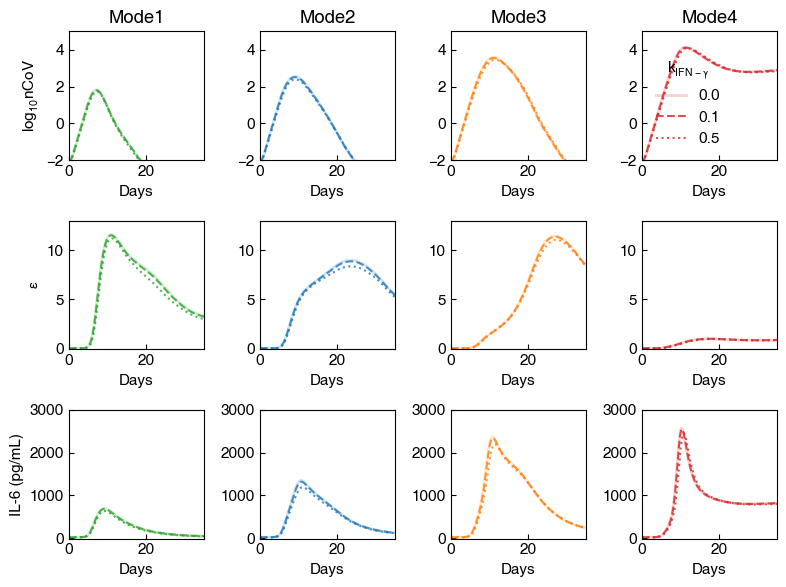

In [16]:
data_mean = {'mode': [], 'k_IFNg': [], 'sol': []}
for mode in [1, 2, 3, 4]:
    for k_ifng in k_IFNg_list:
        # num_mode = (np.array(data['new_mode']) == mode) # reclassifying
        num_mode = (np.array(data['mode']) == mode) # orginal mode
        num_kifng = (np.array(data['k_IFNg']) == k_ifng)
        num_select = num_mode*num_kifng

        mean_sol = np.mean(np.array(data['sol'])[num_select], axis=0)

        data_mean['mode'].append(mode)
        data_mean['k_IFNg'].append(k_ifng)
        data_mean['sol'].append(mean_sol)


# Figures
fig, ax = plt.subplots(3, 4, figsize=(8, 6))

for mode in [1, 2, 3, 4]:
    for k_ifng, ls in zip(k_IFNg_list, ['-', '--', ':', '-.']):
        num_mode = (np.array(data_mean['mode']) == mode)
        num_kifng = (np.array(data_mean['k_IFNg']) == k_ifng)
        num_select = np.where(num_mode*num_kifng)[0][0]

        if k_ifng == 0:
            alpha = 0.2
            lw = 2
        else:
            alpha = 0.8
            lw = 1.5

        ax[0, mode-1].plot(Time, data_mean['sol'][num_select][:, 0],
                           label='%.1f' % (k_ifng),
                           c=ggcolors[mode], ls=ls,
                           alpha=alpha, lw=lw)
        
        ax[1, mode-1].plot(Time, data_mean['sol'][num_select][:, 33],
                           label='%.1f' % (k_ifng),
                           c=ggcolors[mode], ls=ls,
                           alpha=alpha, lw=lw)

        ax[2, mode-1].plot(Time, data_mean['sol'][num_select][:, 26],
                           label='%.1f' % (k_ifng),
                           c=ggcolors[mode], ls=ls,
                           alpha=alpha, lw=lw)

        ax[0, mode-1].set_title('Mode%i' % mode)

for a in ax.flat:
    a.set_xlabel('Days')
    a.set_xlim([0, 35])

for a in ax[0, :]:
    a.set_ylim([-2, 5])

for a in ax[1, :]:
    a.set_ylim([-0.1, 13])

for a in ax[2, :]:
    a.set_ylim([-10, 3000])

ax[0, 0].set_ylabel(r'$log_{10}nCoV$')
ax[1, 0].set_ylabel(r'$\epsilon$')
ax[2, 0].set_ylabel('IL-6 (pg/mL)')
ax[0, -1].legend(title=r'$k_{IFN-\gamma}$',
                 frameon=False)

plt.tight_layout()
# plt.savefig('Average_IFNeffect.png', dpi=200)
# plt.savefig('Average_IFNeffect.svg', dpi=200)